# Imports & Data

In [ ]:
! pip install langdetect
! pip install evaluimport pandas as pd
! pip install evaluate

import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import langdetect
from langdetect import detect
import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import string

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.gleu_score import corpus_gleu
from nltk.lm import Vocabulary, MLE
from functools import partial
from itertools import chain
from nltk.util import everygrams, pad_sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
import evaluate

nltk.download('punkt')
nltk.download('wordnet')

# Import custom built packages
from data_cleaning import *
from data_collection import *
from entity_recognition import *
from lda_topic_modeling import *
from plot import *
from summarization_accuricies import Accuracies

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

pd.set_option('display.max_rows', 500)
pd.options.display.width = 0

my_drive = '/content/drive/MyDrive/UChicago/6 - spring 2023/Advanced Machine Learning/project/'
#/content/drive/MyDrive/UChicago/6 - spring 2023/Advanced Machine Learning/project/articles.csv



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
data = pd.read_csv(f'{my_drive}articles.csv')
publications = pd.read_csv(f'{my_drive}publications.csv')
publications_new = pd.read_csv(f'{my_drive}summaries_v1.csv')
data.shape

(204, 3)

In [ ]:
# Import all summaries and create table with human summary
cnn66 = pd.read_csv(f'{my_drive}summaries_cnn_66.csv', lineterminator='\n')
samsum = pd.read_csv(f'{my_drive}summaries_v_cnn_cansum.csv', lineterminator='\n')
summary_comparison_df = cnn66.merge(samsum, how='inner',on='Title')
summary_comparison_df.drop_duplicates(subset='Title', inplace=True)
summary_comparison_df = summary_comparison_df[['Title', 'Program_x', 'Full_Report_x', 'Content_x', 'summaries_x', 'summaries_y']]
summary_comparison_df.rename({'Content_x':'Human Summary',
                              'Program_x':'Program',
                              'Full_Report_x':'Full Report',
                              'summaries_x':'CNN 6-6 Summary',
                              'summaries_y':'CNN Sam Sum Summary'}, inplace=True,axis=1)

# Accuracy Columns
summary_comparison_df.head()

,Title,Program,Full Report,Human Summary,CNN 6-6 Summary,CNN Sam Sum Summary
0,Policy Brief: Policies and Enabling Environmen...,NaN,policies and enabling environment to drive pr...,identifying priority actions for decarbonizing...,India's target of net-zero emissions (nze) by ...,Industrial emission accounts for one-third of ...
1,Impact and Highlights from CPI’s Climate Finan...,Climate Finance Tracking,climate finance tracking program impact and hi...,photo by hendrik cornelissen our 2022 highligh...,climate finance tracking program impact and h...,Cpi’s climate finance tracking program provide...
2,Challenges of Rural Insurance in the Context o...,Brazil Policy Center,promoting the modernization and sustainability...,promoting the modernization and sustainability...,The current context of climate change amplifi...,The current context of climate change amplifie...
3,An Innovative IFI Operating Model for the 21st...,San Giorgio Group,an inno vative ifi operating model for the 21...,photo by kalen emsley last year saw major cont...,An inno vative ifi operating model for the 21...,The discussion paper is based on the discussio...
4,Emissions Accounting in Managed Coal Phaseout ...,Climate Finance,2 emissions accounting in manage...,to meet the global temperature goal of the par...,The authors would like to acknowledge and tha...,The authors acknowledge the advisory council a...


# Isolate English Texts

In [ ]:
# Use functions from custom built data_cleaning package
data = elim_non_str(data, 'Content')
data = add_lang_col(data, 'Content')
data = isolate_en(data)

publications = elim_non_str(publications, 'Content')
publications = add_lang_col(publications, 'Content')
publications = elim_non_str(publications, 'Full_Report')
publications = add_lang_col(publications, 'Full_Report')
publications = isolate_en(publications)
publications.head()

Eliminated 1 non-string entries, from 204 to 203
Eliminated 36 non-English entries, from 203 to 167
Eliminated 5 non-string entries, from 469 to 464
Eliminated 40 non-string entries, from 464 to 424
This row throws and error: 382
Eliminated 47 non-English entries, from 424 to 377


,Title,Content,Program,Full_Report,Language
0,Policy Brief: Policies and Enabling Environmen...,Identifying Priority Actions for Decarbonizing...,NaN,Policies and Enabling Environment \nto Drive P...,en
1,Impact and Highlights from CPI’s Climate Finan...,Photo by Hendrik Cornelissen\nOur 2022 Highlig...,Climate Finance Tracking,Climate Finance Tracking Program\nImpact and H...,en
3,Challenges of Rural Insurance in the Context o...,Promoting the modernization and sustainability...,Brazil Policy Center,Promoting the modernization and sustainability...,en
4,An Innovative IFI Operating Model for the 21st...,Photo by Kalen Emsley\nLast year saw major con...,San Giorgio Group,An Inno\nvative IFI Operating \nModel for the ...,en
7,Emissions Accounting in Managed Coal Phaseout ...,To meet the global temperature goal of the Par...,Climate Finance,2 \n \n \n \n \n \n \nEmissions Accounting in ...,en


# Clean Text

In [ ]:
# Clean data using functions from custom built package data_cleaning
data = clean_text(data, 'Content')
publications = clean_text(publications, 'Content')
publications = clean_text(publications, 'Full_Report')

# LDA Topic Modeling

In [ ]:
# Load stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Fun LDA on full data
# Evaluate topics for text
text_topics(data, 'Full Report')

[(0, '0.027*"energy" + 0.019*"renewable" + 0.017*"carbon" + 0.014*"investment" + 0.012*"new" + 0.011*"instruments" + 0.010*"brasil" + 0.009*"low" + 0.009*"climate" + 0.008*"global"'), (1, '0.035*"climate" + 0.023*"initiative" + 0.020*"usd" + 0.018*"policy" + 0.014*"billion" + 0.014*"cpi" + 0.014*"indonesia" + 0.011*"sustainable" + 0.011*"finance" + 0.011*"global"'), (2, '0.067*"climate" + 0.031*"finance" + 0.026*"global" + 0.019*"new" + 0.016*"policy" + 0.013*"investment" + 0.013*"lab" + 0.012*"billion" + 0.011*"study" + 0.011*"energy"'), (3, '0.039*"climate" + 0.038*"finance" + 0.017*"india" + 0.016*"initiative" + 0.015*"policy" + 0.014*"energy" + 0.011*"cpi" + 0.011*"report" + 0.008*"sustainable" + 0.007*"partners"'), (4, '0.034*"de" + 0.031*"climate" + 0.023*"initiative" + 0.021*"policy" + 0.017*"brasil" + 0.012*"na" + 0.011*"new" + 0.011*"cpi" + 0.008*"launches" + 0.008*"energy"'), (5, '0.032*"de" + 0.016*"brasil" + 0.015*"study" + 0.013*"climate" + 0.012*"da" + 0.012*"brazil" + 0.

# Entity Recognition

In [ ]:
spacy.cli.download("en_core_web_sm")
NER = spacy.load("en_core_web_sm")

def spacy_large_ner(document):
  return {(ent.text.strip(), ent.label_) for ent in NER(document).ents}

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Use entity recognition model to identify entities in texts
# Store them in "Entities" column of data
entities = []
for text in data['Content']:
  entities.append(spacy_large_ner(text))
data['Entities'] = entities
data

,Title,Content,Program,Language,Entities
0,Cities Climate Finance Leadership Alliance (CC...,ccfla welcomes members in central asia to enga...,Cities Climate Finance Leadership Alliance,en,"{(384 billion, CARDINAL), (annual, DATE), (the..."
3,Global Innovation Lab for Climate Finance anno...,16 march 2023london – members of the global in...,Global Innovation Lab for Climate Finance,en,"{(21 964637061sam, QUANTITY), (equality“we, PE..."
4,Climate Policy Initiative and Power Foundation...,as per updated nationally determined contribut...,NaN,en,"{(2005, DATE), (2030cpi, CARDINAL), (the unite..."
5,CPI Expands Board with Renowned Climate Financ...,climate policy initiative cpi whose mission is...,NaN,en,"{(2021, CARDINAL), (the brazilian development ..."
8,CPI Global Managing Director appointed to Ener...,climate policy initiative cpi is pleased to an...,NaN,en,"{(dr buchner, PERSON), (one, CARDINAL), (the r..."
9,The IKEA Foundation and Climate Policy Initiat...,the ikea foundation and climate policy initiat...,Climate Finance,en,"{(an additional €1 billion, MONEY), (15 17 mil..."
14,CPI announces key role in supporting Indonesia...,a new multistakeholder partnership to accelera...,NaN,en,"{(cpi indonesiathe jetp package, ORG), (2030“w..."
15,CPI launches Rooftop Solar Investment Accelera...,new incubation facility from climate policy in...,Climate Finance,en,"{(688, CARDINAL), (23, CARDINAL), (dr barbara ..."
16,U.S. announces USD 2 million to support the La...,washington dc – today the us government announ...,Global Innovation Lab for Climate Finance,en,"{(186 million, CARDINAL), (washington, GPE), (..."
17,Applications open for the Global Innovation La...,the lab is looking for six earlystage innovati...,Global Innovation Lab for Climate Finance,en,"{(african, NORP), (east african, NORP), (india..."


# Hugging Face Pre-trained Model [Experiment, not in final results]

In [ ]:
from transformers import pipeline
##[{ "summary_text": " Paris is the capital and most populous city of France..." }]
text = 'Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018, in an area of more than 105 square kilometres (41 square miles). The City of Paris is the centre and seat of government of the region and province of Île-de-France, or Paris Region, which has an estimated population of 12,174,880, or about 18 percent of the population of France as of 2017.'

classifier = pipeline("summarization")
classifier(text)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Your max_length is set to 142, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


[{'summary_text': ' Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018 . The city is the centre and seat of government of the region and province of Île-de-France, or Paris Region . Paris Region has an estimated 18 percent of the population of France as of 2017 .'}]

In [ ]:
text=publications['Full_Report'][0]
print(len(text))
classifier(text[0:5000])

48236


[{'summary_text': ' Industrial emission accounts for about onethird of all global anthropogenic co2 emissions . Steel and cement are the most consumed emissionintensive industrial materials and india is the second largest producer of both these materials combined they account for 1520 of india’s emissions . In a businessasusual scenario emissions from these sectors are expected to increase threefold by 2050 .'}]

In [ ]:
publications['Hugging Face Summary'] = publications['Full_Report'].map(lambda x: classifier(x[0:2500]))
publications

,Title,Content,Program,Full_Report,Language,Hugging Face Summary
0,Policy Brief: Policies and Enabling Environmen...,identifying priority actions for decarbonizing...,NaN,policies and enabling environment to drive pri...,en,[{'summary_text': ' Industrial emission accoun...
1,Impact and Highlights from CPI’s Climate Finan...,photo by hendrik cornelissenour 2022 highlight...,Climate Finance Tracking,climate finance tracking programimpact and hig...,en,[{'summary_text': ' Climate finance tracking p...
3,Challenges of Rural Insurance in the Context o...,promoting the modernization and sustainability...,Brazil Policy Center,promoting the modernization and sustainability...,en,[{'summary_text': ' The modernization and sust...
4,An Innovative IFI Operating Model for the 21st...,photo by kalen emsleylast year saw major contr...,San Giorgio Group,an innovative ifi operating model for the 21st...,en,[{'summary_text': ' an innovative ifi operatin...
7,Emissions Accounting in Managed Coal Phaseout ...,to meet the global temperature goal of the par...,Climate Finance,2 emissions accounting in managed coal p...,en,[{'summary_text': ' The authors would like to ...
8,Where Does Brazil Stand and Where Is It Headin...,foto cristina leme lopeswhere do we standthe y...,Brazil Policy Center,march 2023action based agenda1where does brazi...,en,[{'summary_text': ' The year 2022 marks the 10...
9,Global Landscape of Renewable Energy Finance 2023,global investment in energy transition technol...,Climate Finance Tracking,2023global landscape of renewable energy finan...,en,[{'summary_text': ' Report was jointly prepare...
10,CCFLA: 2022 Highlights and Impact,the cities climate finance leadership alliance...,Cities Climate Finance Leadership Alliance,2022 highlights and impact2table of contents01...,en,[{'summary_text': ' The cities climate finance...
11,Smallholders in the Caatinga and the Cerrado: ...,due to the increasingly high global carbon emi...,Brazil Policy Center,smallholders in the caatinga and the cerrado a...,en,[{'summary_text': ' smallholders in the caatin...
13,Guidelines to Assess the Direct and Indirect A...,climate policy initiativepucrio in partnership...,Brazil Policy Center,guidelines to assess the direct and indirect ...,en,[{'summary_text': ' guidelines to assess the ...


# Accuracies


In [ ]:
# Taking a smaller sample to calculate metrics on
summaries = publications.Content[378:]
references = publications.Full_Report[378:]

# Take a look at the summaries
print(summaries)

# Calculate metrics using custom accuracy measures
acc = Accuracies(references, summaries)
bleu = acc.calculate_bleu()
meteor = acc.calculate_meteor()
info_gain = acc.calculate_information_gain()

378    This “Background Report on Long-term Climate F...
379    Geothermal energy holds significant promise fo...
380    The Government of India has set ambitious rene...
381    Executive summary\nThe Governments of Indonesi...
382    As nations work to address climate change, acc...
383    Executive Summary\nIndia has ambitious targets...
384    This publication is CPI’s analysis of Climate ...
385    Executive Summary\nGeothermal energy holds sig...
386    This analysis, conducted by CPI/PUC-Rio, shows...
387    Executive Summary\nBrazil faces a dual challen...
388    Description\nPrivate investors – often support...
389    Executive Summary\nIn December 2015, countries...
390    In Central Kalimantan CPI partners with the Pa...
391    Many nations face the challenge of reconciling...
392    Executive Summary\nGeothermal energy is broadl...
393                                                  NaN
394    In 2007, 36 Brazilian municipalities were resp...
395    The worldwide energy eff

AttributeError: ignored

In [ ]:
# Add custom accuracy metrics to df
accuracies = pd.DataFrame(list(zip(bleu, meteor, info_gain)),
               columns =['bleu', 'meteor', 'info_gain'])

publications['Accuracy: Bleu'] = accuracies['bleu']
publications['Accuracy: Meteor'] = accuracies['meteor']
publications['Information Gain'] = accuracies['info_gain']

In [ ]:
# Import all summaries and create table with human summary
cnn66 = pd.read_csv(f'{my_drive}summaries_cnn_66.csv', lineterminator='\n')
samsum = pd.read_csv(f'{my_drive}summaries_v_cnn_cansum.csv', lineterminator='\n')
summary_comparison_df = cnn66.merge(samsum, how='inner',on='Title')
summary_comparison_df.drop_duplicates(subset='Title', inplace=True)
summary_comparison_df = summary_comparison_df[['Title', 'Program_x', 'Full_Report_x', 'Content_x', 'summaries_x', 'summaries_y']]
summary_comparison_df.rename({'Content_x':'Human Summary',
                              'Program_x':'Program',
                              'Full_Report_x':'Full Report',
                              'summaries_x':'CNN 6-6 Summary',
                              'summaries_y':'CNN Sam Sum Summary'}, inplace=True,axis=1)

# Accuracy Columns
# Instantiate accuracy classes for each summary type
acc_human = Accuracies(summary_comparison_df['Full Report'], summary_comparison_df['Human Summary'])
acc_cnn66 = Accuracies(summary_comparison_df['Full Report'], summary_comparison_df['CNN 6-6 Summary'])
acc_cnnsamsum = Accuracies(summary_comparison_df['Full Report'], summary_comparison_df['CNN Sam Sum Summary'])

# Create bleu summaries
summary_comparison_df['Bleu Human'] = acc_human.calculate_bleu()
summary_comparison_df['Bleu CNN 6-6']= acc_cnn66.calculate_bleu()
summary_comparison_df['Bleu CNN Sam Sum'] = acc_cnnsamsum.calculate_bleu()

# Create Meteor summaries
summary_comparison_df['Meteor Human'] = acc_human.calculate_meteor2()
summary_comparison_df['Meteor CNN 6-6']= acc_cnn66.calculate_meteor2()
summary_comparison_df['Meteor CNN Sam Sum'] = acc_cnnsamsum.calculate_meteor2()

# If you would like to calculate information gain as an additional metric, you can do so here
# Create Information Gain summaries
#summary_comparison_df['Meteor Human'] = acc_human.calculate_information_gain()
#summary_comparison_df['Meteor CNN 6-6']= acc_cnn66.calculate_information_gain()
#summary_comparison_df['Meteor CNN Sam Sum'] = acc_cnnsamsum.calculate_information_gain()

# Option to save info
#summary_comparison_df.to_csv(f'{my_drive}summary_comparison_df.csv')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Results

In [ ]:
# Option to read in results if you have them saved rather than re-running all code
# summary_comparison_df = pd.read_csv(f'{my_drive}cleaned_publications.csv', lineterminator='\n')

Calculate Results

In [ ]:
# Find the max accuracy across all summaries (human vs CNN 6-6 vs CNN Sam Sum)
summary_comparison_df['max_bleu'] = summary_comparison_df[['Bleu Human',	'Bleu CNN 6-6',	'Bleu CNN Sam Sum']].idxmax(axis=1)
summary_comparison_df['max_meteor'] = summary_comparison_df[['Meteor Human',	'Meteor CNN 6-6',	'Meteor CNN Sam Sum']].idxmax(axis=1)

# Calculate differences between accuracy scores
summary_comparison_df['bleu-human-cnn66'] = summary_comparison_df['Bleu Human'] -	 summary_comparison_df['Bleu CNN 6-6']
summary_comparison_df['bleu-human-cnnsamsum'] = summary_comparison_df['Bleu Human'] -	 summary_comparison_df['Bleu CNN Sam Sum']

summary_comparison_df['meteor-human-cnn66'] = summary_comparison_df['Meteor Human'] -	 summary_comparison_df['Meteor CNN 6-6']
summary_comparison_df['meteor-human-cnnsamsum'] = summary_comparison_df['Meteor Human'] -	 summary_comparison_df['Meteor CNN Sam Sum']

summary_comparison_df.head()

,Title,Program,Full Report,Human Summary,CNN 6-6 Summary,CNN Sam Sum Summary,Bleu Human,Bleu CNN 6-6,Bleu CNN Sam Sum,Meteor Human,Meteor CNN 6-6,Meteor CNN Sam Sum,max_bleu,max_meteor,bleu-human-cnn66,bleu-human-cnnsamsum,meteor-human-cnn66,meteor-human-cnnsamsum
0,Policy Brief: Policies and Enabling Environmen...,NaN,policies and enabling environment to drive pr...,identifying priority actions for decarbonizing...,India's target of net-zero emissions (nze) by ...,Industrial emission accounts for one-third of ...,0.003879,2.354573e-63,8.583706e-43,0.092118,0.004651,0.006275,Bleu Human,Meteor Human,0.003879,0.003879,0.087467,0.085843
1,Impact and Highlights from CPI’s Climate Finan...,Climate Finance Tracking,climate finance tracking program impact and hi...,photo by hendrik cornelissen our 2022 highligh...,climate finance tracking program impact and h...,Cpi’s climate finance tracking program provide...,0.000023,3.976540e-11,2.114854e-13,0.047719,0.026031,0.025671,Bleu Human,Meteor Human,0.000023,0.000023,0.021688,0.022048
2,Challenges of Rural Insurance in the Context o...,Brazil Policy Center,promoting the modernization and sustainability...,promoting the modernization and sustainability...,The current context of climate change amplifi...,The current context of climate change amplifie...,0.811369,2.902349e-73,1.925316e-68,0.600441,0.003306,0.003708,Bleu Human,Meteor Human,0.811369,0.811369,0.597135,0.596733
3,An Innovative IFI Operating Model for the 21st...,San Giorgio Group,an inno vative ifi operating model for the 21...,photo by kalen emsley last year saw major cont...,An inno vative ifi operating model for the 21...,The discussion paper is based on the discussio...,0.000646,2.432964e-36,7.224281e-26,0.080141,0.011214,0.012135,Bleu Human,Meteor Human,0.000646,0.000646,0.068927,0.068006
4,Emissions Accounting in Managed Coal Phaseout ...,Climate Finance,2 emissions accounting in manage...,to meet the global temperature goal of the par...,The authors would like to acknowledge and tha...,The authors acknowledge the advisory council a...,0.000058,5.640676e-55,6.963353e-44,0.057272,0.004627,0.006777,Bleu Human,Meteor Human,0.000058,0.000058,0.052645,0.050495


In [ ]:
# Sort accuracies to find highest rated summaries
highest_sam_sum = summary_comparison_df.sort_values(['Bleu CNN Sam Sum'],ascending=False).head()
highest_sam_sum

,Title,Program,Full Report,Human Summary,CNN 6-6 Summary,CNN Sam Sum Summary,Bleu Human,Bleu CNN 6-6,Bleu CNN Sam Sum,Meteor Human,Meteor CNN 6-6,Meteor CNN Sam Sum,max_bleu,max_meteor,bleu-human-cnn66,bleu-human-cnnsamsum,meteor-human-cnn66,meteor-human-cnnsamsum
316,Fact Sheet: Supporting Sustainable Development...,NaN,p: +62 (0) 536 4200208 f: +62 (0) 536 420020...,in central kalimantan cpi partners with the pa...,Palangkaraya institute for land and agricultur...,Palangkaraya Institute for Land and Agricultur...,3.588290e-01,3.394706e-03,0.014202,0.389785,0.108395,0.173045,Bleu Human,Meteor Human,0.355434,0.344627,0.281391,0.216741
220,An Assessment of India’s Energy Choices,Climate Finance,an assessment of india’s energy choices forew...,india’s economy is growing rapidly and with it...,India's economy is growing rapidly and so is i...,The government of India is committed to achiev...,1.724341e-01,3.659416e-04,0.002278,0.409405,0.085192,0.095368,Bleu Human,Meteor Human,0.172068,0.170156,0.324213,0.314037
192,Assessing the Capital Costs of Maximizing Sust...,Brazil Policy Center,assessing the capital costs...,introduction increasing agricultural productiv...,climate policy initiative (cpi) and núcleo de...,"Arthur Braganca, Juliano Assuncao, CPPI and nú...",4.215218e-02,1.813264e-05,0.002161,0.198504,0.088804,0.109451,Bleu Human,Meteor Human,0.042134,0.039991,0.109701,0.089053
244,Why are Land Rights Important to Brazil?,Brazil Policy Center,climate policy initiative/ puc-rio works to im...,secure rural land rights would benefit the who...,climate policy initiative/ puc-rio works to i...,Climate policy initiative/ puc-rio works to im...,1.760915e-11,1.080699e-04,0.000330,0.027831,0.063869,0.081137,Bleu CNN Sam Sum,Meteor CNN Sam Sum,-0.000108,-0.000330,-0.036038,-0.053306
141,Monetizing Water Savings,Climate Finance,climatefinancelaborg1 innovation mws coordinat...,this publication is cpi’s analysis of monetizi...,The pilot project targets water efficiency of...,Mws coordinates the efforts of government corp...,6.885942e-01,2.306769e-07,0.000183,0.627663,0.050610,0.082735,Bleu Human,Meteor Human,0.688594,0.688411,0.577052,0.544928


Evaluate/Analyze Results

In [ ]:
# Isolate best scoring summary to review if it makes sense
highest_66_1 = summary_comparison_df[summary_comparison_df['Title']=="Impact and Highlights from CPI’s Climate Finance Tracking Program"]
highest_66_2 = summary_comparison_df[summary_comparison_df['Title']=="An Innovative IFI Operating Model for the 21st Century"]
highest_66_1

,Title,Program,Full Report,Human Summary,CNN 6-6 Summary,CNN Sam Sum Summary,Bleu Human,Bleu CNN 6-6,Bleu CNN Sam Sum,Meteor Human,Meteor CNN 6-6,Meteor CNN Sam Sum,max_bleu,max_meteor,bleu-human-cnn66,bleu-human-cnnsamsum,meteor-human-cnn66,meteor-human-cnnsamsum
1,Impact and Highlights from CPI’s Climate Finan...,Climate Finance Tracking,climate finance tracking program impact and hi...,photo by hendrik cornelissen our 2022 highligh...,climate finance tracking program impact and h...,Cpi’s climate finance tracking program provide...,0.000023,3.976540e-11,2.114854e-13,0.047719,0.026031,0.025671,Bleu Human,Meteor Human,0.000023,0.000023,0.021688,0.022048


In [ ]:
# Calculate average accuracies across human vs model accuracies for each accuracy type
diff_results = pd.DataFrame(summary_comparison_df[['bleu-human-cnn66',	'bleu-human-cnnsamsum',	'meteor-human-cnn66',	'meteor-human-cnnsamsum']].mean(axis=0),columns=['Difference between Humans & Model Accuracies'])
diff_results

,Difference between Humans & Model Accuracies
bleu-human-cnn66,0.122225
bleu-human-cnnsamsum,0.122185
meteor-human-cnn66,0.136602
meteor-human-cnnsamsum,0.135254


In [ ]:
# Find topics in report overall
summary_comparison_df['Topics Full Report'] = text_topics(summary_comparison_df, 'Full Report')

[(0, '0.012*"energy" + 0.010*"finance" + 0.007*"climate" + 0.006*"investment" + 0.005*"renewable" + 0.004*"development" + 0.004*"private" + 0.004*"financial" + 0.004*"zerotab" + 0.004*"project"'), (1, '0.012*"climate" + 0.010*"finance" + 0.008*"energy" + 0.006*"investment" + 0.006*"projects" + 0.005*"policy" + 0.005*"risk" + 0.004*"public" + 0.004*"sector" + 0.004*"development"'), (2, '0.011*"energy" + 0.009*"climate" + 0.009*"finance" + 0.006*"investment" + 0.005*"project" + 0.005*"renewable" + 0.004*"financing" + 0.004*"also" + 0.004*"cost" + 0.004*"public"'), (3, '0.014*"finance" + 0.011*"climate" + 0.007*"energy" + 0.005*"private" + 0.005*"investment" + 0.004*"development" + 0.004*"risk" + 0.004*"projects" + 0.004*"policy" + 0.004*"renewable"'), (4, '0.011*"energy" + 0.009*"climate" + 0.007*"finance" + 0.005*"investment" + 0.005*"development" + 0.005*"risk" + 0.005*"project" + 0.004*"projects" + 0.004*"policy" + 0.004*"cost"'), (5, '0.009*"finance" + 0.009*"climate" + 0.008*"energy

Graphing

Text(0.5, 0, '')

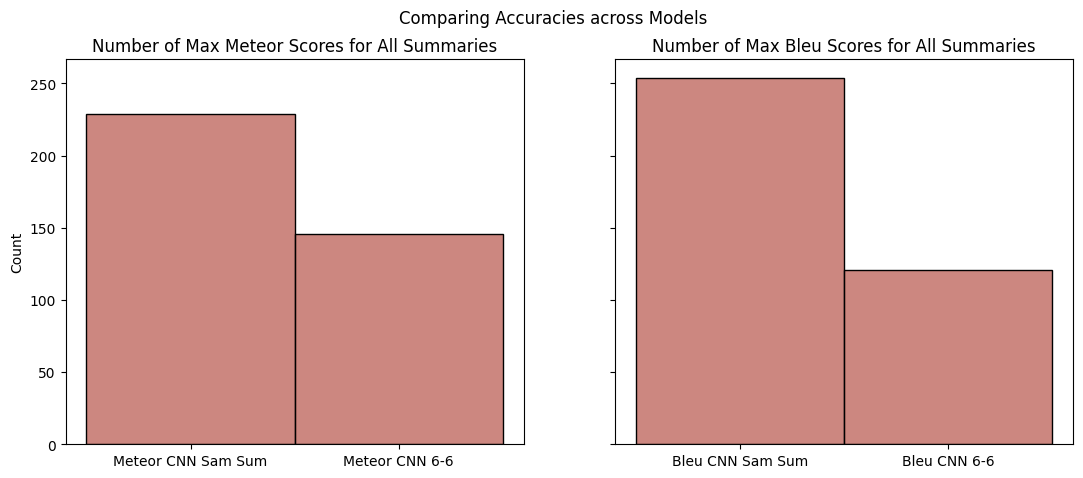

In [ ]:
# Plot accuracies across models and accuracy types
# Highlight the number of times each model scores the highest (human summaries
# not included here because far and away the most maximum scores, see following
# charts)
summary_comparison_df['max_bleu_model_only'] = summary_comparison_df[['Bleu CNN 6-6',	'Bleu CNN Sam Sum']].idxmax(axis=1)
summary_comparison_df['max_meteor_model_only'] = summary_comparison_df[['Meteor CNN 6-6',	'Meteor CNN Sam Sum']].idxmax(axis=1)

COLOR ='#BC5F55'
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
fig.suptitle('Comparing Accuracies across Models')

sns.histplot(summary_comparison_df.max_meteor_model_only, ax=axes[0],color=COLOR)
axes[0].set_title('Number of Max Meteor Scores for All Summaries')
axes[0].set_xlabel('')

sns.histplot(summary_comparison_df.max_bleu_model_only, ax=axes[1],color=COLOR)
axes[1].set_title('Number of Max Bleu Scores for All Summaries')
axes[1].set_xlabel('')


Text(0.5, 0, '')

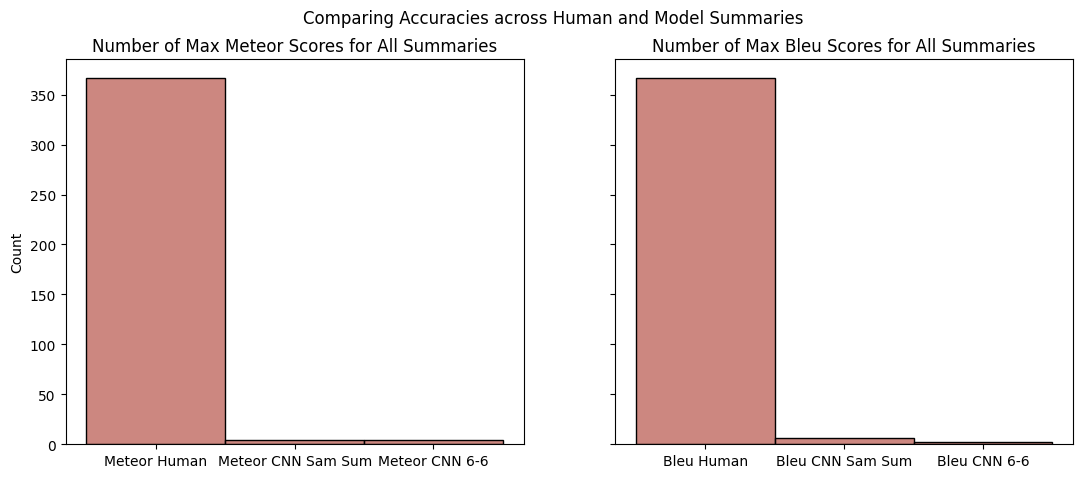

In [ ]:
# Plot accuracies across models and accuracy types
# Highlight the number of times each model and human summaries scores the highest

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
fig.suptitle('Comparing Accuracies across Human and Model Summaries')

sns.histplot(summary_comparison_df.max_meteor, ax=axes[0],color=COLOR)
axes[0].set_title('Number of Max Meteor Scores for All Summaries')
axes[0].set_xlabel('')

sns.histplot(summary_comparison_df.max_bleu, ax=axes[1],color=COLOR)
axes[1].set_title('Number of Max Bleu Scores for All Summaries')
axes[1].set_xlabel('')